In [19]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

NX = 9
NY = 6
OFFSET = 0
TEST_IMAGE = 'test_images/test5.jpg'
OUTPUT_IMAGE_DIR = 'output_images'

In [20]:
def collectCorners(imageFiles, nx, ny):
    '''
    '''
    objPoints = []
    imagePoints = []

    objPoint = np.zeros((ny*nx,3), np.float32)
    objPoint[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for imageFile in imageFiles:
        image = mpimg.imread(imageFile)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objPoints.append(objPoint)
            imagePoints.append(corners)
            
    return objPoints,imagePoints

def undistort(image, objPoints, imagePoints):
    '''
    '''
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imagePoints, (image.shape[1], image.shape[0]), None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)

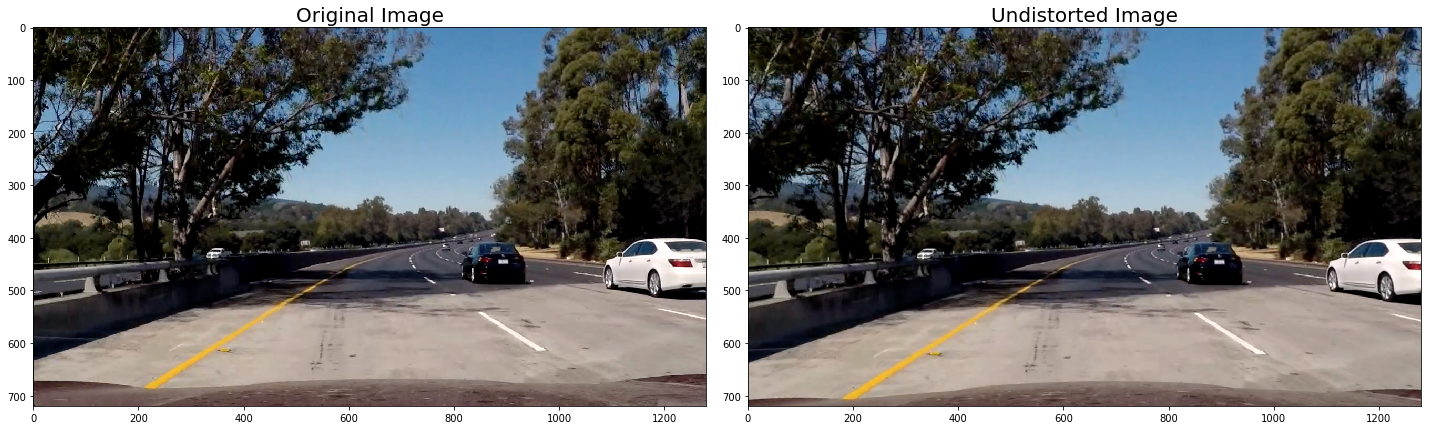

In [21]:
imageFiles = glob.glob('camera_cal/*.jpg')
objPoints,imagePoints = collectCorners(imageFiles, NX, NY)

image = mpimg.imread(TEST_IMAGE)
undistorted = undistort(image, objPoints, imagePoints)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'undistorted.jpg'))

In [22]:
def thresholdColorGradient(undistorted, sThreshold=(130,255), xThreshold=(15,100)):
    '''
    '''
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS).astype(np.float)
    lChannel = hls[:,:,1]
    sChannel = hls[:,:,2]

    # Sobel x
    # Take the derivative in x
    # Absolute x derivative to accentuate lines away from horizontal
    sobelX = cv2.Sobel(lChannel, cv2.CV_64F, 1, 0)
    absSobelX = np.absolute(sobelX)
    xSobel = np.uint8(255 * absSobelX/np.max(absSobelX))

    # Threshold x gradient
    xBinary = np.zeros_like(xSobel)
    xBinary[(xThreshold[0] <= xSobel) & (xSobel <= xThreshold[1])] = 1

    # Threshold color channel
    sBinary = np.zeros_like(sChannel)
    sBinary[(sThreshold[0] <= sChannel) & (sChannel <= sThreshold[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    colorBinary = np.dstack((np.zeros_like(xBinary), xBinary, sBinary))

    # Combine the two binary thresholds
    combinedBinary = np.zeros_like(xBinary)
    combinedBinary[(sBinary == 1) | (xBinary == 1)] = 1

    return combinedBinary,colorBinary

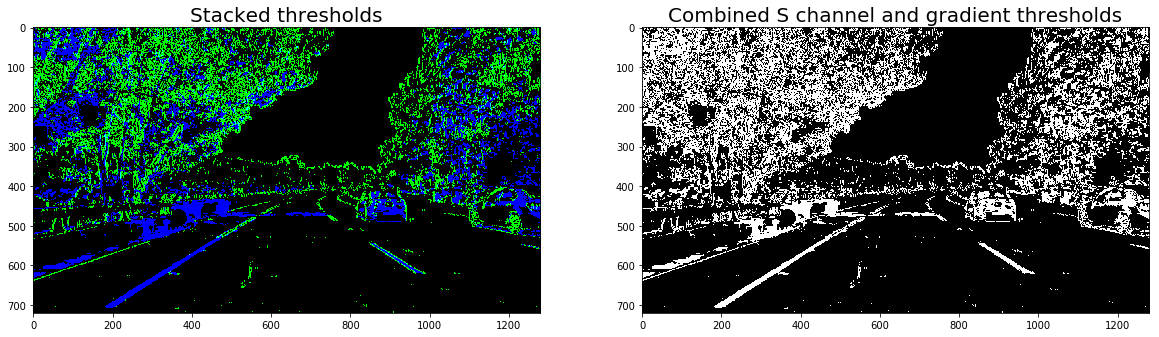

In [23]:
combinedBinary,colorBinary = thresholdColorGradient(undistorted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax2.set_title('Combined S channel and gradient thresholds', fontsize=20)
ax2.imshow(combinedBinary, cmap='gray')

ax1.set_title('Stacked thresholds', fontsize=20)
ax1.imshow(colorBinary)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'binary.jpg'))

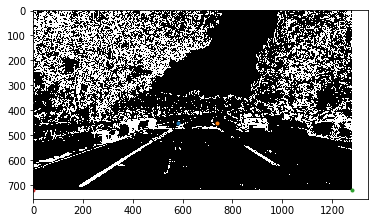

In [24]:
imageSize = (combinedBinary.shape[1], combinedBinary.shape[0]) 

upperLeft = [580, 450]
upperRight = [740, 450]
lowerRight = [imageSize[0], imageSize[1]]
lowerLeft = [0, imageSize[1]]

plt.imshow(combinedBinary, cmap='gray')
plt.plot(upperLeft[0],upperLeft[1],".")
plt.plot(upperRight[0],upperRight[1],".")
plt.plot(lowerRight[0], lowerRight[1], ".")
plt.plot(lowerLeft[0], lowerRight[1], ".")

In [25]:
def warp(undistorted, offset=OFFSET):
    '''
    '''
    imageSize = (undistorted.shape[1], undistorted.shape[0]) 
    
    srcRegion = [upperLeft,
                 upperRight,
                 lowerRight,
                 lowerLeft]
    
    dstRegion = [[offset, offset],
                 [imageSize[0]-offset, offset], 
                 [imageSize[0]-offset, imageSize[1]-offset], 
                 [offset, imageSize[1]-offset]]
    
    # Choose some points to be a nice fit for displaying the warped result for destination points    
    src = np.float32(srcRegion)
    dst = np.float32(dstRegion)
    
    # Calculate the perspective transform matrix given src and dst points, and
    # Warp the image using OpenCV warpPerspective()
    perspective = cv2.getPerspectiveTransform(src, dst)
    inversePerspective = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undistorted, perspective, imageSize, flags=cv2.INTER_LINEAR)
    
    return warped, inversePerspective

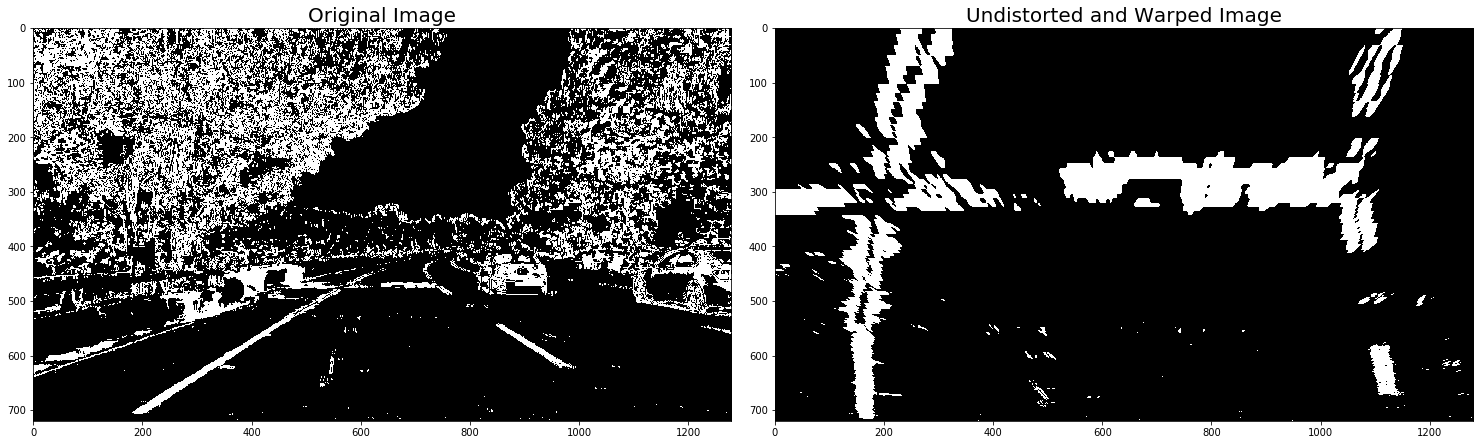

In [26]:
warped, inversePerspective = warp(combinedBinary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(combinedBinary, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'warped_binary.jpg'))

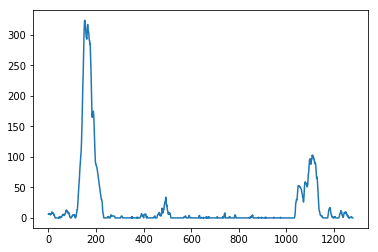

In [27]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [28]:
def measureCarvature(leftX, leftY, rightX, rightY, plotY):
    '''
    '''
    def curveRadius(fit, yValue, yMeterPerPixels):
        return ((1 + (2 * fit[0] * yValue * yMeterPerPixels + fit[1])**2)**1.5) / np.absolute(2 * fit[0])

    xMeterPerPixels = 3.7/700 # meters per pixel in x dimension    
    yMeterPerPixels = 30/720 # meters per pixel in y dimension

    # Fit new polynomials to x,y in world space
    leftFit = np.polyfit(leftY * yMeterPerPixels, leftX * xMeterPerPixels, 2)
    rightFit = np.polyfit(rightY * yMeterPerPixels, rightX * xMeterPerPixels, 2)
    
    # Calculate the new radii of curvature
    yValue = np.max(plotY)    
    leftCurveRadius = curveRadius(leftFit, yValue, yMeterPerPixels)
    rightCurveRadius = curveRadius(rightFit, yValue, yMeterPerPixels)
    
    # Now our radius of curvature is in meters
    return leftCurveRadius, rightCurveRadius

In [29]:
def firstFrameProcessed():
    firstFrameProcessed.done = True
    
def fit(left, right):
    fit.left = left
    fit.right = right

# Utility functions
def nonzeroIndices(lowX, highX, lowY, highY, nonzeroX, nonzeroY):
    return ((lowY <= nonzeroY) & (nonzeroY < highY) & (lowX <= nonzeroX) & (nonzeroX < highX)).nonzero()[0]

def laneIndices(fit, nonzeroX, nonzeroY, margin):
    def f(fit, nonzeroX, nonzeroY, margin):
        return (((fit[0]*(nonzeroY**2) + fit[1]*nonzeroY + fit[2] - margin) < nonzeroX) &
            (nonzeroX < (fit[0]*(nonzeroY**2) + fit[1]*nonzeroY + fit[2] + margin)))
    
    leftLaneIndices = f(fit.left, nonzeroX, nonzeroY, margin)
    rightLaneIndices = f(fit.right, nonzeroX, nonzeroY, margin)
    
    return leftLaneIndices, rightLaneIndices

def polynomials(fit, plotY):
    def f(fit, plotY):
        return fit[0] * plotY**2 + fit[1] * plotY + fit[2]
        
    leftFit = f(fit.left, plotY)
    rightFit = f(fit.right, plotY)
    
    return leftFit, rightFit

def findLanes(warped, numberOfWindows=9, windowMargin=100, minPixels=50):
    # x and y positions of all nonzero pixels in the image
    nonzeroX = []
    nonzeroY = []
    
    # Left and right lane pixel indices
    leftLaneIndices = []
    rightLaneIndices = []
    
    # Left and right lane pixel positions
    leftX = []
    leftY = []
    rightX = []
    rightY = []
      
    if not firstFrameProcessed.done:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midPoint = np.int(histogram.shape[0]/2)
        leftBaseX = np.argmax(histogram[:midPoint])
        rightBaseX = np.argmax(histogram[midPoint:]) + midPoint
        
        # Set height of windows
        windowHeight = np.int(warped.shape[0]/numberOfWindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroY = np.array(nonzero[0])
        nonzeroX = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftCurrentX = leftBaseX
        rightCurrentX = rightBaseX
        
        # Step through the windows one by one
        for index in range(numberOfWindows):
            # Identify window boundaries in x and y (and right and left)
            lowY = warped.shape[0] - (index+1) * windowHeight
            highY = warped.shape[0] - index * windowHeight
            leftLowX = leftCurrentX - windowMargin
            leftHighX = leftCurrentX + windowMargin
            rightLowX = rightCurrentX - windowMargin
            rightHighX = rightCurrentX + windowMargin
            
            # Identify the nonzero pixels in x and y within the window
            leftNonzeroIndices = nonzeroIndices(leftLowX, leftHighX, lowY, highY, nonzeroX, nonzeroY)
            rightNonzeroIndices = nonzeroIndices(rightLowX, rightHighX, lowY, highY, nonzeroX, nonzeroY)
            
            # Append these indices to the lists
            leftLaneIndices.extend(leftNonzeroIndices)
            rightLaneIndices.extend(rightNonzeroIndices)
            
            # If you found > minPixels pixels, recenter next window on their mean position
            if minPixels < len(leftNonzeroIndices):
                leftCurrentX = np.int(np.mean(nonzeroX[leftNonzeroIndices]))
                
            if minPixels < len(rightNonzeroIndices):
                rightCurrentX = np.int(np.mean(nonzeroX[rightNonzeroIndices]))
    
        # Extract left and right line pixel positions
        leftX = nonzeroX[leftLaneIndices]
        leftY = nonzeroY[leftLaneIndices]
        rightX = nonzeroX[rightLaneIndices]
        rightY = nonzeroY[rightLaneIndices]
        
        # Fit a second order polynomial
        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)
        fit(leftFit, rightFit)
        
        firstFrameProcessed()
    else:
        nonzero = warped.nonzero()
        nonzeroY = np.array(nonzero[0])
        nonzeroX = np.array(nonzero[1])
        
        leftLaneIndices,rightLaneIndices = laneIndices(fit, nonzeroX, nonzeroY, windowMargin)
        
        # Extract left and right line pixel positions
        leftX = nonzeroX[leftLaneIndices]
        leftY = nonzeroY[leftLaneIndices]
        rightX = nonzeroX[rightLaneIndices]
        rightY = nonzeroY[rightLaneIndices]
        
        # Fit a second order polynomial
        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)
        fit(leftFit, rightFit)
        
    # Generate x and y values for plotting
    plotY = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    leftFitX, rightFitX = polynomials(fit, plotY)
    
    # Measure curvature here
    leftCurveRadius,rightCurveRadius = measureCarvature(leftX, leftY, rightX, rightY, plotY)
    
    # Start drawing the image from here
    output = np.dstack((warped, warped, warped))*255    
    windowImage = np.zeros_like(output)
    
    # Color in left and right line pixels
    output[nonzeroY[leftLaneIndices], nonzeroX[leftLaneIndices]] = [255, 0, 0]
    output[nonzeroY[rightLaneIndices], nonzeroX[rightLaneIndices]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # Then, recast the x and y points into usable format for cv2.fillPoly()
    leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitX - windowMargin, plotY]))])
    leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitX + windowMargin, plotY])))])
    leftLinePoints = np.hstack((leftLineWindow1, leftLineWindow2))
    
    rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitX - windowMargin, plotY]))])
    rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitX + windowMargin, plotY])))])
    rightLinePoints = np.hstack((rightLineWindow1, rightLineWindow2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(windowImage, np.int_([leftLinePoints]), (0,255, 0))
    cv2.fillPoly(windowImage, np.int_([rightLinePoints]), (0,255, 0))
    lanes = cv2.addWeighted(output, 1, windowImage, 0.3, 0)
    
    return lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius

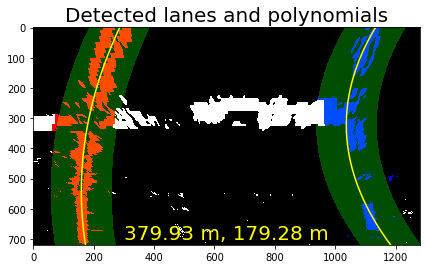

In [30]:
# Left and right second order polynomials
fit.left = []
fit.right = []
firstFrameProcessed.done = False 

lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius = findLanes(warped)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.imshow(lanes)
ax.set_title('Detected lanes and polynomials', fontsize=20)
ax.plot(leftFitX, plotY, color='yellow')
ax.plot(rightFitX, plotY, color='yellow')
ax.text(300, 700,'%.2f m, %.2f m' % (leftCurveRadius, rightCurveRadius), color='yellow', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'lanes_polynomials.jpg'))

In [31]:
def projectLanes(originalImage, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY):
    zeroWarp = np.zeros_like(warped).astype(np.uint8)
    colorWarp = np.dstack((zeroWarp, zeroWarp, zeroWarp))

    # Recast the x and y points into usable format for cv2.fillPoly()
    leftPoints = np.array([np.transpose(np.vstack([leftFitX, plotY]))])
    rightPoints = np.array([np.flipud(np.transpose(np.vstack([rightFitX, plotY])))])
    points = np.hstack((leftPoints, rightPoints))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorWarp, np.int_([points]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    backed = cv2.warpPerspective(colorWarp, inversePerspective, (originalImage.shape[1], originalImage.shape[0]))
    # Combine the result with the original image
    return cv2.addWeighted(undistorted, 1, backed, 0.3, 0)

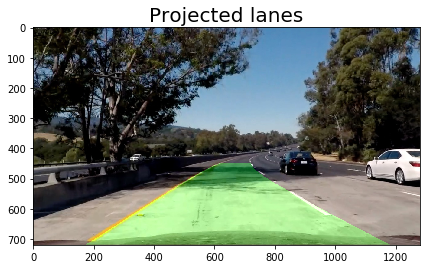

In [32]:
projected = projectLanes(image, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.imshow(projected)
ax.set_title('Projected lanes', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'projected.jpg'))

In [33]:
fit.left = []
fit.right = []
firstFrameProcessed.done = False 

def project(image):
    '''
    '''
    undistorted = undistort(image, objPoints, imagePoints)
    combinedBinary, colorBinary = thresholdColorGradient(undistorted)
    warped, inversePerspective = warp(combinedBinary)
    lanes, leftFitX, rightFitX, plotY, leftCurveRadius, rightCurveRadius = findLanes(warped)
    return projectLanes(image, undistorted, warped, inversePerspective, leftFitX, rightFitX, plotY)

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
projectOutput = 'project.mp4'
clipProject = VideoFileClip("project_video.mp4")
projectClip = clipProject.fl_image(project)
%time projectClip.write_videofile(projectOutput, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [25:12<00:00,  1.20it/s]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 17min 46s, sys: 32.7 s, total: 18min 19s
Wall time: 25min 14s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(projectOutput))